In [129]:
import pandas as pd
from pandas.core.series import Series
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import mapply
mapply.init(n_workers=7, progressbar=True)


# Read the data
INCIDENTS = '../../dataset/data-raw/incidents.csv'
POVERTYYEAY = '../../dataset/data-raw/povertyByStateYear.csv'
STATEDISHOUSE = '../../dataset/data-raw/year_state_district_house.csv'
POPULATION = '../../dataset/data-raw/population.csv'

incidents = pd.read_csv(INCIDENTS)
poverty = pd.read_csv(POVERTYYEAY)
state_district_house = pd.read_csv(STATEDISHOUSE)
population = pd.read_csv(POPULATION, index_col=0)

incidents['state'] = incidents['state'].str.upper()
poverty['state'] = poverty['state'].str.upper()
state_district_house['state'] = state_district_house['state'].str.upper()

incidents['date_year'] = incidents['date'].str.split('-').str[0].astype(int)
incidents['date_month'] = incidents['date'].str.split('-').str[1].astype(int)
incidents['date_day'] = incidents['date'].str.split('-').str[2].astype(int)
del incidents['date']

population['NAME'] = population['NAME'].str.upper()

incidents = incidents[['date_year', 'date_month', 'date_day', 'state', 'city_or_county', 'latitude', 'longitude', 'congressional_district', 'min_age_participants', 'avg_age_participants', 'max_age_participants', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants', 'incident_characteristics1']].copy()


/tmp/ipykernel_67817/3238715173.py:16: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents = pd.read_csv(INCIDENTS)


In [95]:
population_clean = population.copy()
population_clean = population_clean.drop(columns=['CENSUS2010POP', 'ESTIMATESBASE2010'])
population_clean.columns = population_clean.columns.str.removeprefix('POPESTIMATE')
# given columns like 2010, 2011, ... 2019, we want to have a column year and a column population
population_clean = population_clean.melt(id_vars=['NAME'], var_name='YEAR', value_name='state_population')
population_clean["YEAR"] = population_clean["YEAR"].astype(float)

In [2]:
# set non-numeric values to NaN in columns supposed to be numeric

objcols = incidents.select_dtypes(include=['object']).columns
objcols = objcols.drop(['state', 'city_or_county', 'incident_characteristics1'])

for col in objcols:
    incidents[col] = incidents[col].mapply(pd.to_numeric, errors='coerce')

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

In [3]:
# Infer the congressional district when missing as the most common one in the city
# TO-OPTIMIZE: it would be faster to crack RSA-2048 on a TI-84
def find_cd(row):
    df = incidents[(incidents['state'] == row['state']) * (incidents['city_or_county'] == row['city_or_county'])]
    # find the most common congressional district
    vc = df['congressional_district'].value_counts()
    if vc.empty:
        row['congressional_district'] = np.nan
        return row
    cd = vc.idxmax()
    row['congressional_district'] = cd
    return row

# set out-of-semnsible ranga values to NaN
def sensibleValues(row):
    # --- range checks ---
    if row['date_year'] > 2020:
        row['date_year'] = np.nan
    if row['min_age_participants'] > 110 or row['min_age_participants'] < 0:
        row['min_age_participants'] = np.nan
    if row['avg_age_participants'] > 110 or row['avg_age_participants'] < 0:
        row['avg_age_participants'] = np.nan
    if row['max_age_participants'] > 110 or row['max_age_participants'] < 0:
        row['max_age_participants'] = np.nan
    # 103 is the maximum value of n_participants
    if row['n_participants_child'] > 103 or row['n_participants_child'] < 0:
        row['n_participants_child'] = np.nan
    if row['n_participants_teen'] > 103 or row['n_participants_teen'] < 0:
        row['n_participants_teen'] = np.nan
    if row['n_participants_adult'] > 103 or row['n_participants_adult'] < 0:
        row['n_participants_adult'] = np.nan
    if row['n_killed'] > 103 or row['n_killed'] < 0:
        row['n_killed'] = np.nan
    if row['n_injured'] > 103 or row['n_injured'] < 0:
        row['n_injured'] = np.nan
    if row['n_arrested'] > 103 or row['n_arrested'] < 0:
        row['n_arrested'] = np.nan
    if row['n_unharmed'] > 103 or row['n_unharmed'] < 0:
        row['n_unharmed'] = np.nan
    return row


sincidents = incidents.mapply(sensibleValues, axis=1)

sincidents['state_city'] = sincidents['state'] + "-" + sincidents['city_or_county']
cd_df = sincidents[['state_city', 'congressional_district']]
cd_vc = cd_df.groupby('state_city')['congressional_district'].value_counts()
cd_vc = cd_vc.reset_index(name='count')
cd_vc = cd_vc.groupby('state_city').head(1)

def fix_cd(row):
    if np.isnan(row['congressional_district']):
        should_be = cd_vc[cd_vc['state_city'] == row['state_city']]
        if should_be.empty:
            row['congressional_district'] = np.nan
        else:
            row['congressional_district'] = should_be['congressional_district'].values[0]
    return row

sincidents = sincidents.mapply(fix_cd, axis=1)
sincidents = sincidents.drop('state_city', axis=1)

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

In [15]:
# given the groups 
#   (n_participants)
#   (n_males, n_females)
#   (n_participants_child, n_participants_teen, n_participants_adult)
#   (n_killed, n_injured, n_arrested, n_unharmed)
# we find and solve inconsistencies between their sums, keeping the original proportions
# Example:
#   n_participants = 10
#   n_participants_child
#       + n_participants_teen
#       + n_participants_adult = 10
#   n_males = 2
#   n_females = 6
# then the most probable values (according to our assumptions) are groups that sum to 10 so:
#   n_males => 3
#   n_females => 7

from random import randint, choice

# Don't ask, it works (maybe)
def mf(row):
    mf = row['n_males'] + row['n_females']
    cta = row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult']
    kiau = row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed']
    p = row['n_participants']

    ret = 0b0000
    if np.isnan(mf):
        ret |= 0b1000
    if np.isnan(cta):
        ret |= 0b0100
    if np.isnan(kiau):
        ret |= 0b0010
    if np.isnan(p):
        ret |= 0b0001


    if mf == cta == kiau == p:
        return 0b0000 | ret
    elif mf == cta == kiau:
        return 0b0001 | ret
    elif mf == cta == p:
        return 0b0010 | ret
    elif mf == kiau == p:
        return 0b0100 | ret
    elif cta == kiau == p:
        return 0b1000 | ret
    elif mf == p:
        return 0b0110 | ret
    elif cta == p:
        return 0b1010 | ret
    elif kiau == p:
        return 0b1100 | ret
    elif mf == cta:
        return 0b0011 | ret
    elif mf == kiau:
        return 0b0101 | ret
    elif cta == kiau:
        return 0b1001 | ret
    return 0b1111

def perc_calc(vals: list):
    s = np.sum(vals)
    if s == 0:
        return 1/len(vals)
    return vals[0] / s

    
def nannifyErrors(row):
    err_bits = mf(row)
    err_p = err_bits & 0b0001
    err_mf = err_bits & 0b1000
    err_cta = err_bits & 0b0100
    err_kiau = err_bits & 0b0010

    ref = row['n_participants'] if not err_p else \
        row['n_males'] + row['n_females'] if not err_mf else \
        row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult'] if not err_cta else \
        row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed'] if not err_kiau else \
        np.nan
    
    if np.isnan(ref):
        row['n_participants'] = row['n_males'] = row['n_females'] = row['n_participants_child'] = row['n_participants_teen'] = row['n_participants_adult'] = row['n_killed'] = row['n_injured'] = row['n_arrested'] = row['n_unharmed'] = np.nan
        return row

    if err_p:
        row['n_participants'] = ref
    if err_mf:
        p_m = perc_calc([row['n_males'], row['n_females']])
        p_f = 1 - p_m
        # remove float errors
        p_f = p_f if p_f > 1e-6 or np.isnan(p_f) else 0
        row['n_males'] = np.floor(ref * p_m)
        row['n_females'] = np.floor(ref * p_f)
        diff = ref - (row['n_males'] + row['n_females'])
        if diff != 0:
            # With 1/2 probability add the difference to males of females
            row['n_males' if randint(0,1) else 'n_females'] += diff
    if err_cta:
        p_c = perc_calc([row['n_participants_child'], row['n_participants_teen'], row['n_participants_adult']])
        p_t = perc_calc([row['n_participants_teen'], row['n_participants_child'], row['n_participants_adult']])
        p_a = 1 - p_c - p_t
        # remove float errors
        p_a = p_a if p_a > 1e-6 or np.isnan(p_a) else 0
        row['n_participants_child'] = np.floor(ref * p_c)
        row['n_participants_teen'] = np.floor(ref * p_t)
        row['n_participants_adult'] = np.floor(ref * p_a)
        diff = ref - (row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult'])
        if diff != 0:
            to_check = []
            if row['n_participants_child'] != 0:
                to_check.append('n_participants_child')
            if row['n_participants_teen'] != 0:
                to_check.append('n_participants_teen')
            if row['n_participants_adult'] != 0:
                to_check.append('n_participants_adult')
            if len(to_check) == 0:
                to_check = ['n_participants_child', 'n_participants_teen', 'n_participants_adult']
            row[choice(to_check)] += diff
    if err_kiau:
        p_k = perc_calc([row['n_killed'], row['n_injured'], row['n_arrested'], row['n_unharmed']])
        p_i = perc_calc([row['n_injured'], row['n_killed'], row['n_arrested'], row['n_unharmed']])
        p_a = perc_calc([row['n_arrested'], row['n_killed'], row['n_injured'], row['n_unharmed']])
        p_u = 1 - p_k - p_i - p_a
        # remove float errors
        p_u = p_u if p_u > 1e-6 or np.isnan(p_u) else 0
        row['n_killed'] = np.floor(ref * p_k)
        row['n_injured'] = np.floor(ref * p_i)
        row['n_arrested'] = np.floor(ref * p_a)
        row['n_unharmed'] = np.floor(ref * p_u)
        diff = ref - (row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed'])
        if diff != 0:
            to_check = []
            if row['n_killed'] != 0:
                to_check.append('n_killed')
            if row['n_injured'] != 0:
                to_check.append('n_injured')
            if row['n_arrested'] != 0:
                to_check.append('n_arrested')
            if row['n_unharmed'] != 0:
                to_check.append('n_unharmed')
            if len(to_check) == 0:
                to_check = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
            row[choice(to_check)] += diff
    return row



diff = sincidents.mapply(mf, axis=1)
print('DONE diff')
# incidents without problems
dncidents = sincidents[diff == 0b0000]
print('DONE dncidents')
# incidents with problems
wncidents = sincidents[diff != 0b0000].mapply(nannifyErrors, axis=1)
print('DONE wncidents')

# dncidents = incidents.iloc[0:10000].apply(nannifyErrors, axis=1)

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

DONE diff
DONE dncidents


/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

DONE wncidents


In [18]:
# merge wncidents with dncidents
wdincidents = pd.concat([wncidents, dncidents], ignore_index=False)
# shuffle the rows to mix the incidents with problems (wncidents) with the others (dncidents)
wdincidents = wdincidents.sample(frac=1)

In [31]:
cincidents = wdincidents.copy()

print(tabulate(pd.DataFrame(cincidents.isnull().sum(axis=0)).T, headers='keys', tablefmt='psql'))

# cincidents['n_nan'] = cincidents.isnull().sum(axis=1)
# cincidents['n_nan'].value_counts().sort_index().plot.bar()

# 425 bad rows
cincidents = cincidents[~cincidents['congressional_district'].isnull()]
# 326 bad rows
cincidents = cincidents[~cincidents['incident_characteristics1'].isnull()]
# remove all rows where the n_participants groups are all NaN
cincidents = cincidents[~(cincidents[['n_participants', 'n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].isnull().sum(axis=1) == 10)]
print(tabulate(pd.DataFrame(cincidents.isnull().sum(axis=0)).T, headers='keys', tablefmt='psql'))
# drop duplicates
cincidents = cincidents.drop_duplicates()

print(cincidents.shape[0] / incidents.shape[0])

# TEMPORARY: Fix all NaNs with the median of the column
# for col in ['n_participants', 'n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']:
for col in cincidents.select_dtypes(include=['float64']).columns:
    median = cincidents[col].median()
    cincidents[col] = cincidents[col].fillna(median)
# Recheck all participant groups sum to n_participants
cincidents = cincidents.mapply(nannifyErrors, axis=1)


# set as number of days since 2010-01-01
cincidents['timestamp'] = (pd.to_datetime(cincidents[['date_year', 'date_month', 'date_day']].astype(int).astype(str).apply(lambda x: '-'.join(x), axis=1)).astype(int) - pd.to_datetime(['2010-01-04']).astype(int)[0]) / 86400000000000

# cincidents = cincidents.drop(['date_year', 'date_month', 'date_day'], axis=1)
print(tabulate(pd.DataFrame(cincidents.isnull().sum(axis=0)).T, headers='keys', tablefmt='psql'))

+----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+-----------+-------------+------------+-------------+--------------+--------------+------------------+-----------------------------+
|    |   date_year |   date_month |   date_day |   state |   city_or_county |   latitude |   longitude |   congressional_district |   min_age_participants |   avg_age_participants |   max_age_participants |   n_participants_child |   n_participants_teen |   n_participants_adult |   n_males |   n_females |   n_killed |   n_injured |   n_arrested |   n_unharmed |   n_participants |   incident_characteristics1 |
|----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+------------------------+------------------

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

+----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+-----------+-------------+------------+-------------+--------------+--------------+------------------+-----------------------------+-------------+
|    |   date_year |   date_month |   date_day |   state |   city_or_county |   latitude |   longitude |   congressional_district |   min_age_participants |   avg_age_participants |   max_age_participants |   n_participants_child |   n_participants_teen |   n_participants_adult |   n_males |   n_females |   n_killed |   n_injured |   n_arrested |   n_unharmed |   n_participants |   incident_characteristics1 |   timestamp |
|----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+---------------

In [160]:
# Merge with poverty
# poverty header: [state,year,povertyPercentage]
merged = cincidents.merge(poverty, how='left', left_on=['state', 'date_year'], right_on=['state', 'year'])
merged = merged.drop(columns=['year'])

# Merge with state_district_house
# state_district_house header: [year,state,congressional_district,party,candidatevotes,totalvotes]
# state_district_house rows are only for even years but we have incidents for all years
merged['congressional_district'] = merged['congressional_district'].mapply(lambda x: 1 if x == 0 else x)
state_district_house['congressional_district'] = state_district_house['congressional_district'].mapply(lambda x: 1 if x == 0 else x)
stete_district_house_odd = state_district_house.copy()
stete_district_house_odd['year'] = state_district_house['year'] + 1
state_district_house_eo = pd.concat([state_district_house, stete_district_house_odd], ignore_index=True).reset_index(drop=True)

merged = merged.merge(state_district_house_eo, how='left', left_on=['state', 'date_year', 'congressional_district'], right_on=['state', 'year', 'congressional_district'])
merged = merged[(merged['totalvotes'] != 0) * (~merged['totalvotes'].isnull())]

merged = merged.drop(columns=['year'])

# Merge with population
merged = merged.merge(population_clean, how='left', left_on=['state', 'date_year'], right_on=['NAME', 'YEAR'])
merged = merged.drop(columns=['NAME', 'YEAR'])

districts = merged[['state', 'congressional_district', 'date_year', 'totalvotes']].drop_duplicates()
state_totalvotes = districts.groupby(['state', 'date_year'])['totalvotes'].sum()
state_totalvotes = state_totalvotes.sort_index()

# TODO: redo when mentally stable
def estimate_totalvotes(row):
    row['district_population'] = row['state_population'] // state_totalvotes[row['state'], row['date_year']]
    return row

merged = merged.mapply(estimate_totalvotes, axis=1)

# merged.isnull().sum(axis=0)
# merged = merged[~(merged['congressional_district'] == 0)]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

In [35]:
to_corr = ['latitude', 'longitude',
       'min_age_participants',
       'avg_age_participants', 'max_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females',
       'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants',
       'timestamp', 'povertyPercentage', 'candidatevotes', 'totalvotes']

# pd.plotting.scatter_matrix(to_keep_incidents[to_corr], alpha=0.2, figsize=(20, 20), diagonal='kde')

In [36]:
deoutlied = merged.copy()
numeric_cols = deoutlied.select_dtypes(include=['float64', 'int64']).columns
print(numeric_cols)
numeric_cols = numeric_cols.drop(['date_year', 'date_month', 'date_day', 'timestamp', 'latitude', 'longitude', 'congressional_district'])
for col in numeric_cols:
    q1 = deoutlied[col].quantile(0.25)
    q3 = deoutlied[col].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    deoutlied = deoutlied[(deoutlied[col] >= fence_low) * (deoutlied[col] <= fence_high)]

# pd.plotting.scatter_matrix(deoutlied[to_corr], alpha=0.2, figsize=(20, 20), diagonal='hist', s=1.2)


Index(['date_year', 'date_month', 'date_day', 'latitude', 'longitude',
       'congressional_district', 'min_age_participants',
       'avg_age_participants', 'max_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females',
       'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants',
       'timestamp', 'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')


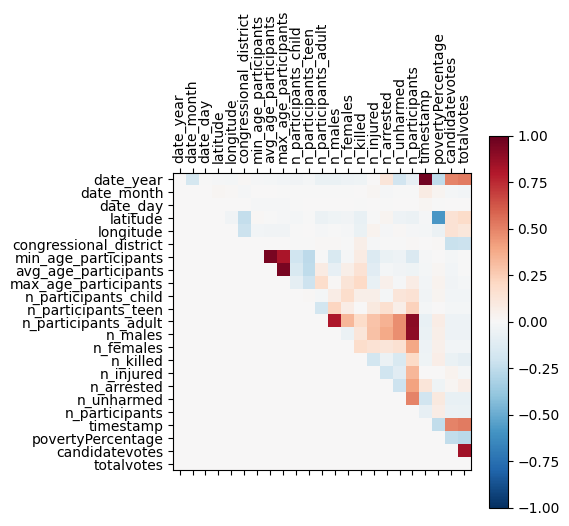

In [37]:
corr = merged.corr(numeric_only=True)
k = 3
# fetch the k more correlated pairs
# corr = corr.abs()
triag = np.triu(np.ones(corr.shape), k=1).astype(float)
corr = corr * triag
# s = corr.unstack()
# so = s.sort_values(kind="quicksort", ascending=False)
# so = so.where((so > 0) & (so < 1)).dropna()
plt.matshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

# Augmentation

In [161]:
augmented_age = merged.copy()

participants_cols = ['n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']

for col in participants_cols:
    new_col_name = 'p_' + col[2:]
    augmented_age[new_col_name] = augmented_age[col] / augmented_age['n_participants']
    
years = augmented_age['date_year'].unique()
states = augmented_age['state'].unique()
per_year = {}
for year in years:
    per_state = {}
    for state in states:
        per_state[state] = augmented_age[(augmented_age['date_year'] == year) * (augmented_age['state'] == state)]
    per_year[year] = per_state
    per_year[year]['all'] = augmented_age[augmented_age['date_year'] == year]

def avg_age_change_state(row):
    avg = row['avg_age_participants']
    state = row['state']
    year = row['date_year']
    if year not in per_year.keys():
        return 0
    affected_state = per_year[year][state]
    affected_avg = affected_state['avg_age_participants'].mean()
    return avg - affected_avg
def avg_age_change(row):
    avg = row['avg_age_participants']
    year = row['date_year']
    if year not in per_year.keys():
        return 0
    affected_all = per_year[year]['all']
    affected_all_avg = affected_all['avg_age_participants'].mean()
    return avg - affected_all_avg

augmented_age['avg_age_change_state'] = augmented_age.mapply(avg_age_change_state, axis=1)
augmented_age['avg_age_change'] = augmented_age.mapply(avg_age_change, axis=1)

# print(tabulate(augmented_age.describe(), headers='keys', tablefmt='psql'))

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/56 [00:00<?, ?it/s]

In [162]:
augmented_multi = augmented_age.copy()

params = participants_cols
new_params = [p + '_ratio' for p in params]

augmented_multi['week'] = np.floor(augmented_multi['timestamp'] / 7)
augmented_multi = augmented_multi.set_index(['week', 'city_or_county'])
augmented_multi = augmented_multi.sort_index()
sums = augmented_multi.groupby(['week', 'city_or_county'])[params].sum()

augmented_multi[new_params] = augmented_multi[params].div(sums, axis=0)
augmented_multi = augmented_multi.reset_index()

# Check 2013/11/21 Philadelphia with Claudia
# For now NaNs are replaced with 0
augmented_multi = augmented_multi.fillna(0)
augmented_multi = augmented_multi.drop(columns=['week'])



In [163]:
augmented_incidents = augmented_multi.copy()

# calculate the aggregated measure `number of incidents per state per month`
augmented_incidents = augmented_incidents.set_index(['date_month', 'date_year', 'state'])
augmented_incidents = augmented_incidents.sort_index()
augmented_incidents['incidents_month_state'] = augmented_incidents.groupby(['date_month', 'date_year', 'state']).size()
augmented_incidents = augmented_incidents.reset_index()

# calculate the aggregated measure `number of incidents per city per month`
augmented_incidents = augmented_incidents.set_index(['date_month', 'date_year', 'city_or_county'])
augmented_incidents = augmented_incidents.sort_index()
augmented_incidents['incidents_month_city'] = augmented_incidents.groupby(['date_month', 'date_year', 'city_or_county']).size()
augmented_incidents = augmented_incidents.reset_index()

# scale previous measures on totalVotes
augmented_incidents['incidents_month_state_scaled'] = augmented_incidents['incidents_month_state'] / augmented_incidents['totalvotes']
augmented_incidents['incidents_month_city_scaled'] = augmented_incidents['incidents_month_city'] / augmented_incidents['totalvotes']

# Percentage of REPUBLICAN and DEMOCRAT votes
REP_df = augmented_incidents[augmented_incidents['party'] == 'REPUBLICAN'].copy()
DEM_df = augmented_incidents[augmented_incidents['party'] == 'DEMOCRAT'].copy()
REP_df['percentage_republican'] = REP_df['candidatevotes'] / REP_df['totalvotes']
REP_df['percentage_democrat'] = 1 - (REP_df['candidatevotes'] / REP_df['totalvotes'])
DEM_df['percentage_democrat'] = DEM_df['candidatevotes'] / DEM_df['totalvotes']
DEM_df['percentage_republican'] = 1 - (DEM_df['candidatevotes'] / DEM_df['totalvotes'])
augmented_incidents = pd.concat([REP_df, DEM_df], ignore_index=True).reset_index(drop=True)

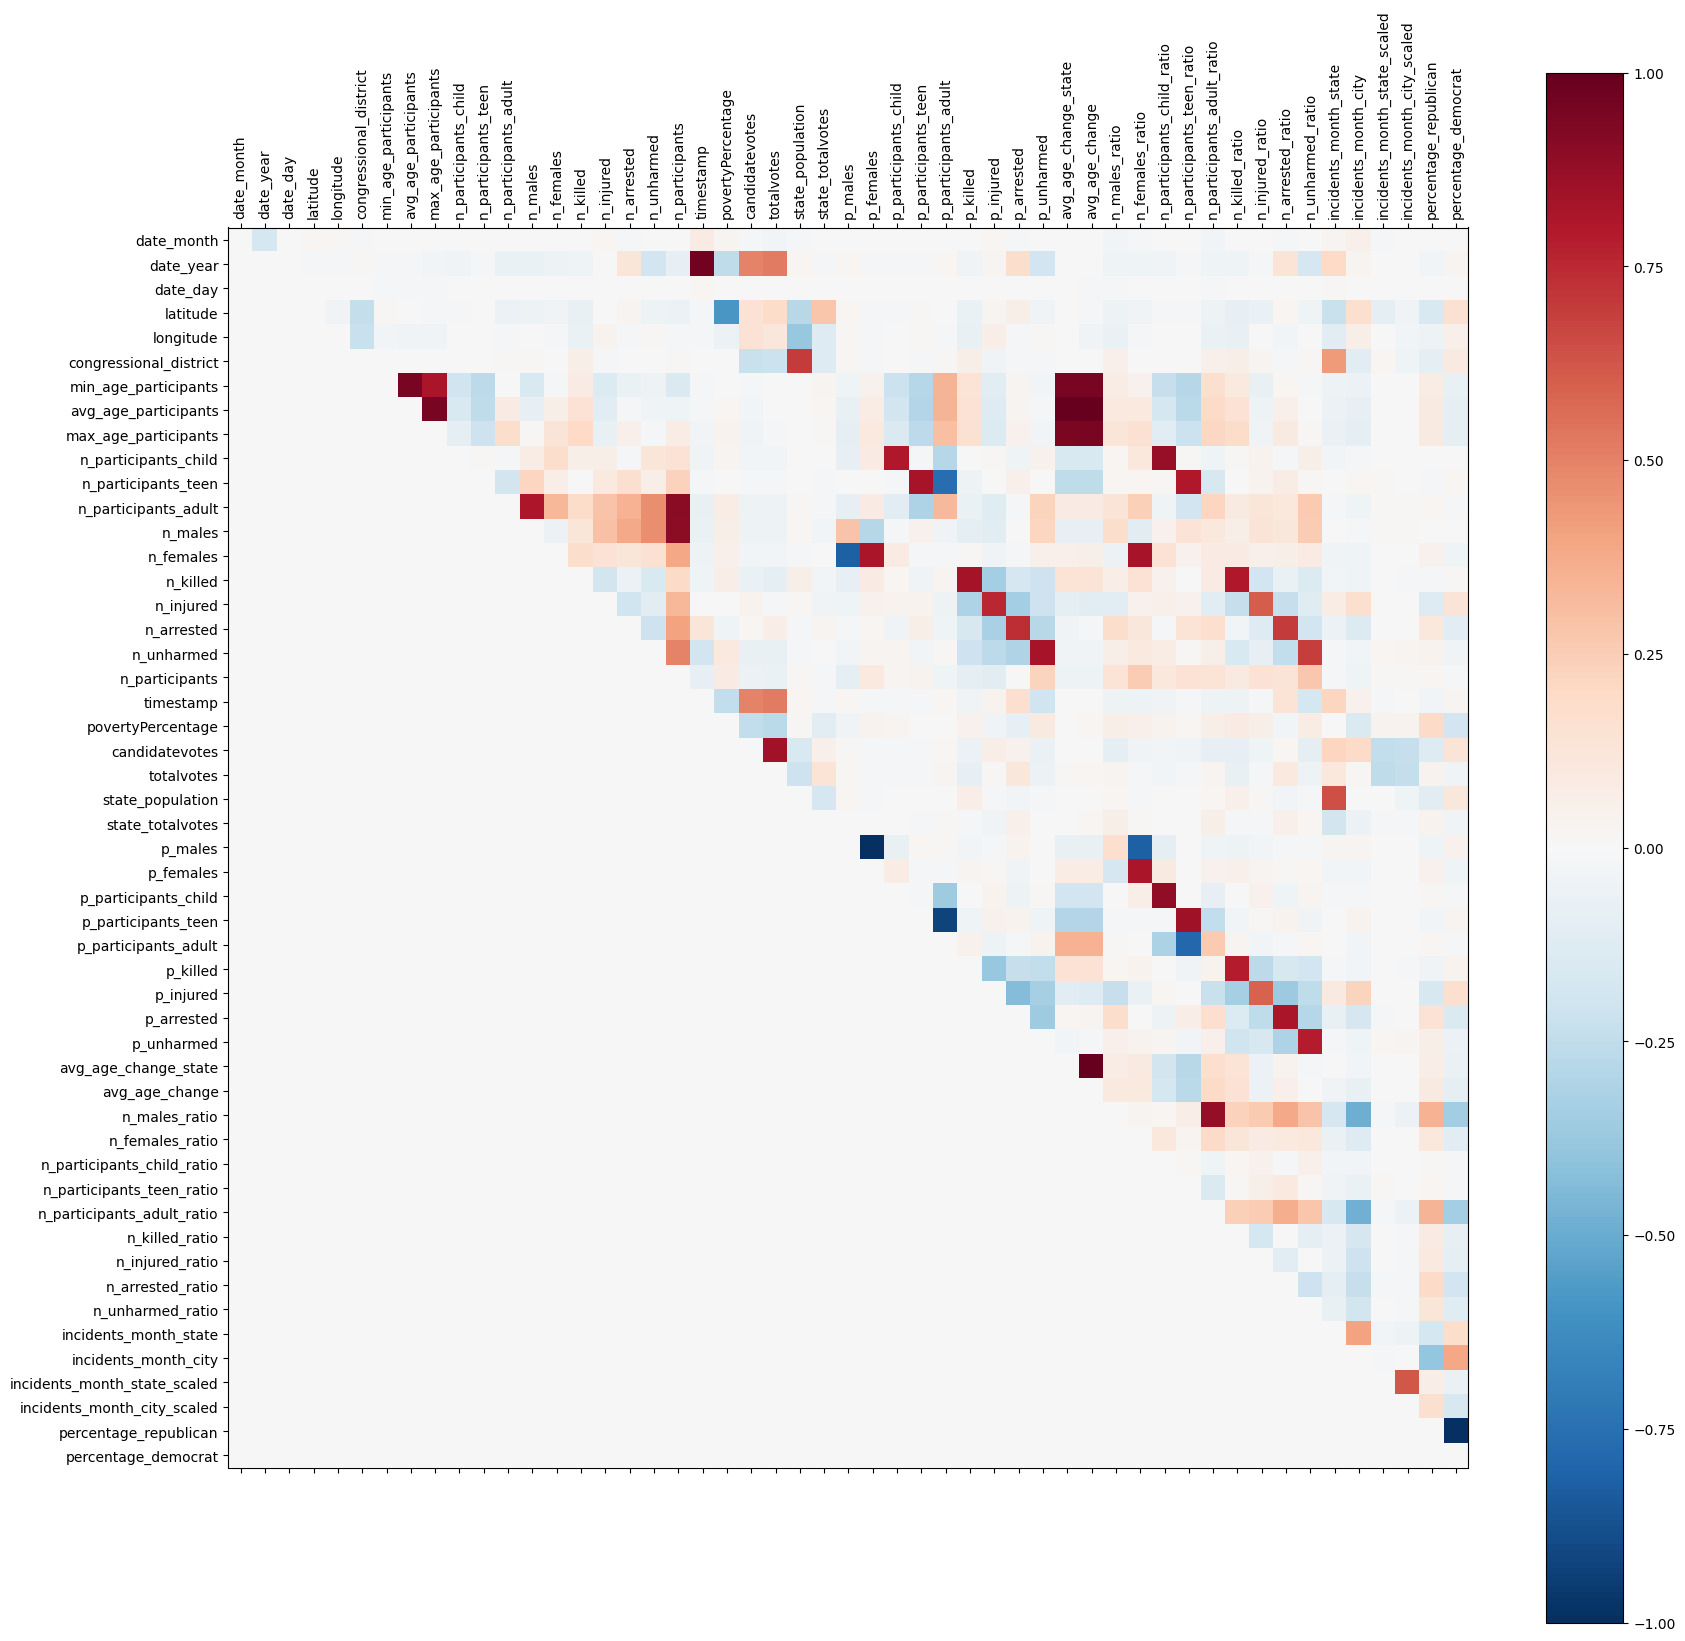

In [164]:
corr = augmented_incidents.corr(numeric_only=True)
k = 3
# fetch the k more correlated pairs
# corr = corr.abs()
triag = np.triu(np.ones(corr.shape), k=1).astype(float)
corr = corr * triag
# s = corr.unstack()
# so = s.sort_values(kind="quicksort", ascending=False)
# so = so.where((so > 0) & (so < 1)).dropna()
plt.figure(figsize=(20,20))
plt.matshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, fignum=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
# change figsize
plt.show()

number of plots: 95


/tmp/ipykernel_67817/1092226154.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


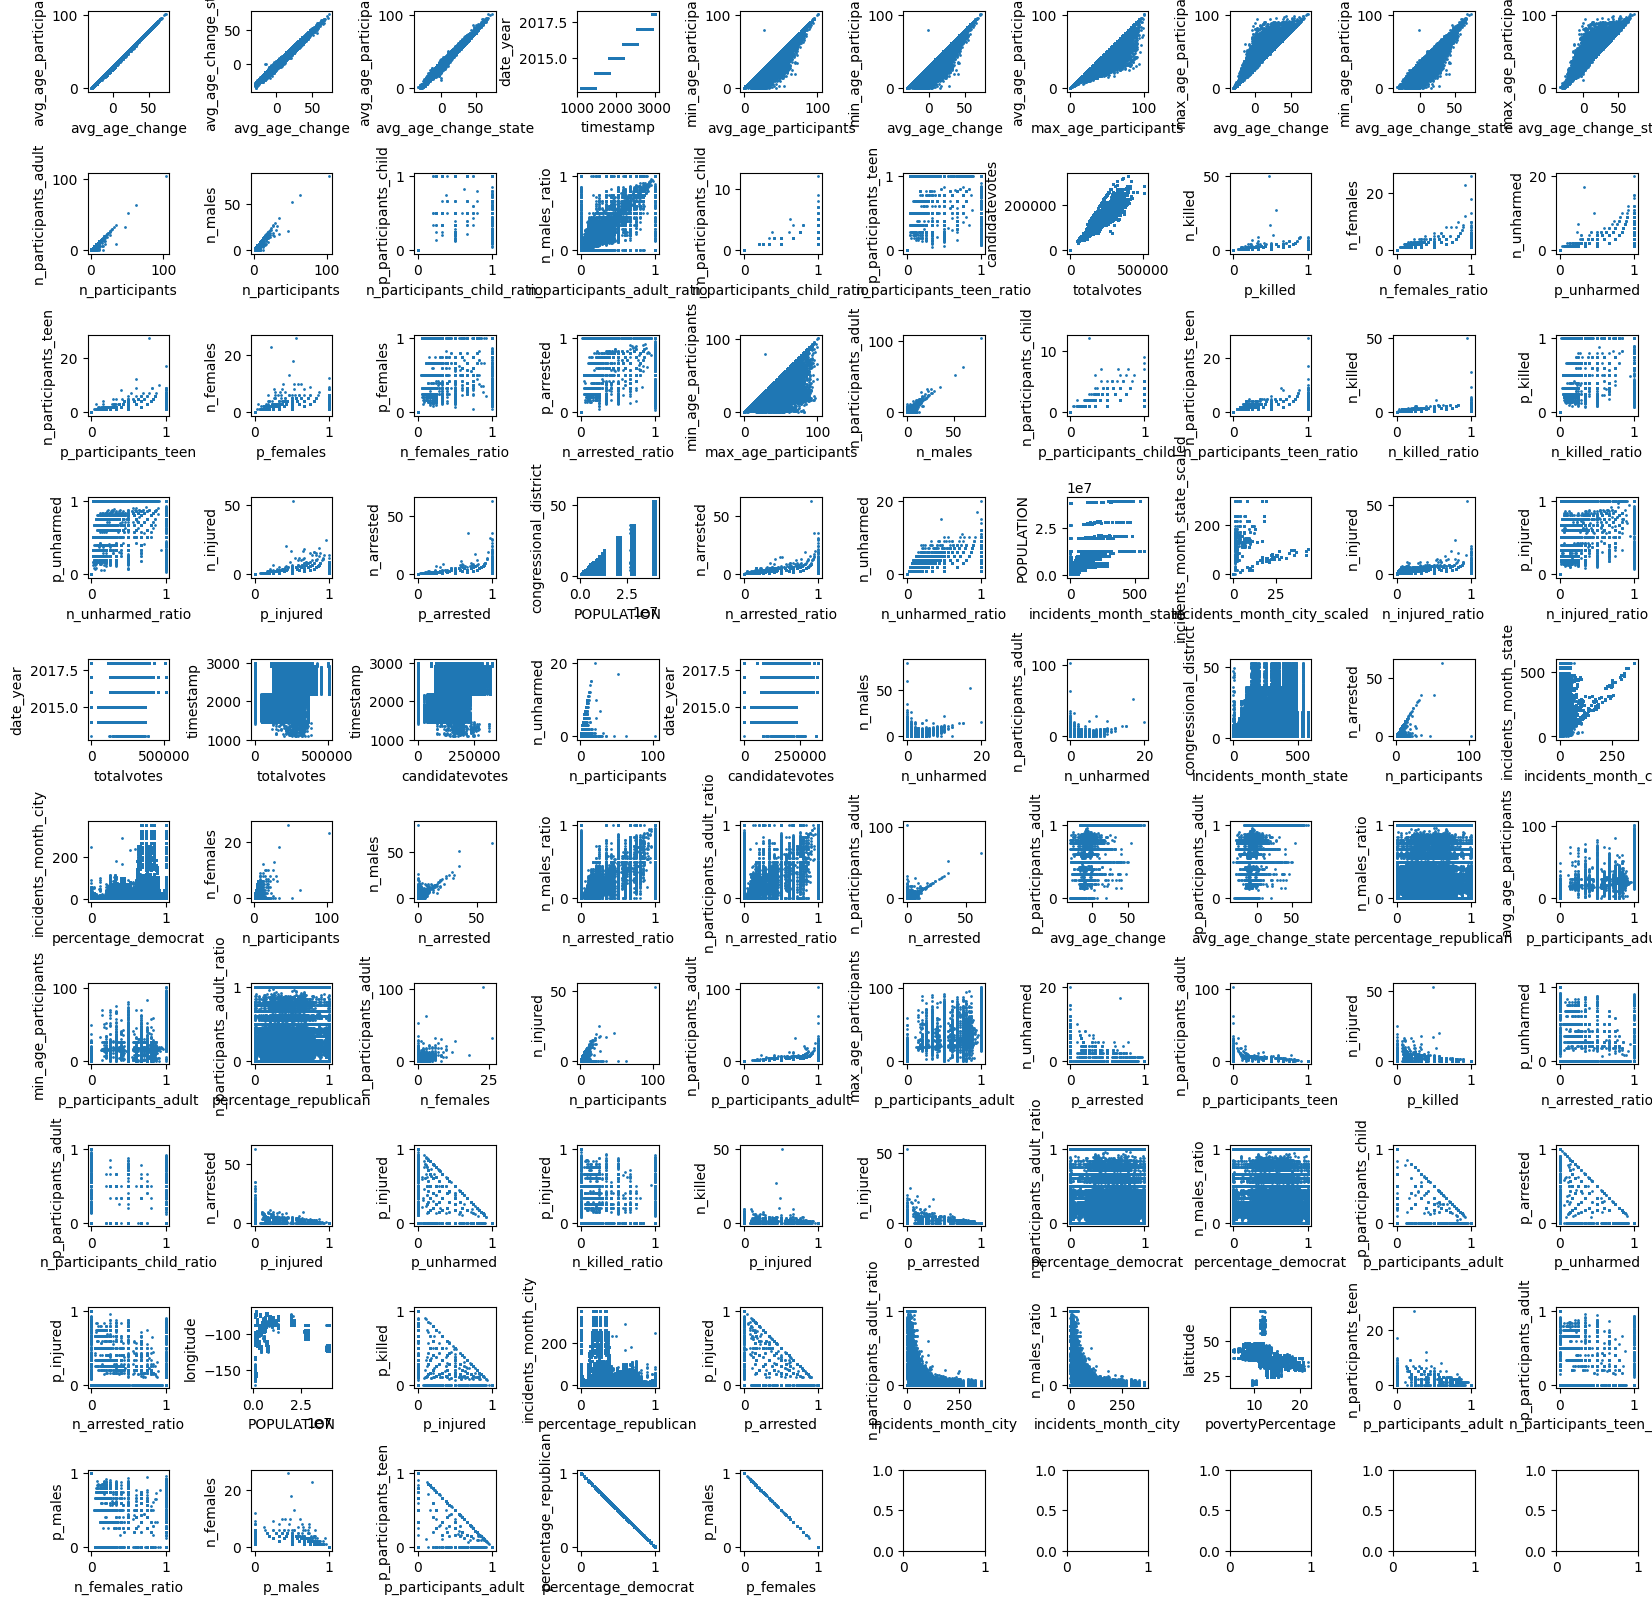

In [94]:
# fetch only corrs that are 0.5 or more
f_corr = corr.where((corr > 0.3) | (corr < -0.3)).dropna(how='all', axis=0).dropna(how='all', axis=1)
f_corr = f_corr.where((corr < 0.9) | (corr > -0.9)).dropna(how='all', axis=0).dropna(how='all', axis=1)
f_corr = f_corr.unstack().dropna().sort_values(kind="quicksort", ascending=False)
print(f"number of plots: {f_corr.shape[0]}")
# scatter plots of the most correlated pairs
fig, axs = plt.subplots(int(np.ceil(np.sqrt(len(f_corr)))), int(np.ceil(np.sqrt(len(f_corr)))), figsize=(20, 20))
# add some space between subplots
fig.subplots_adjust(hspace=1, wspace=1)
for i, (col1, col2) in enumerate(f_corr.index):
    ax = axs[i // int(np.ceil(np.sqrt(len(f_corr)))), i % int(np.ceil(np.sqrt(len(f_corr))))] if len(f_corr) > 1 else axs
    ax.scatter(augmented_incidents[col1], augmented_incidents[col2], s=1)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

fig.show()

Text(0, 0.5, 'state_population')

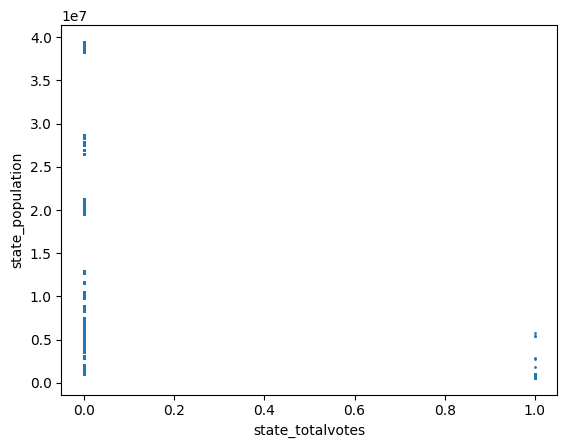

In [167]:
plt.scatter(augmented_incidents['state_totalvotes'], augmented_incidents['state_population'], s=1)
plt.xlabel('state_totalvotes')
plt.ylabel('state_population')

In [ ]:
final_clean = augmented_incidents.copy()